<a href="https://colab.research.google.com/github/mille055/AIPI540_individual_project/blob/main/notebooks/AIPI540_IP_fusion_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

In [1]:
COLAB_FLAG = False   # whether running on colab or locally on computer

In [2]:
if COLAB_FLAG:
    !pip install pydicom==2.1.2
    !pip install monai seaborn sentence_transformers
    !git clone 'https://github.com/mille055/AIPI540_individual_project.git'

    


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import monai
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, GroupKFold, cross_val_score, cross_validate, GroupShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from datetime import datetime
from sentence_transformers import SentenceTransformer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from datetime import datetime
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

import monai
from monai.data import DataLoader, ImageDataset
from monai.transforms import AddChannel, Compose, RandRotate90, Resize, ScaleIntensity, EnsureType
from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import warnings
warnings.filterwarnings("ignore")

2023-04-17 19:53:43,750 - NumExpr defaulting to 8 threads.


In [4]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/AIPI540_individual_project/scripts/')

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/AIPI540_individual_project/scripts/')

### local imports ###
from config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from config import sentence_encoder, series_description_column
from utils import *
from train_pixel_model import train_pix_model, test_pix_model
from train_meta_model import train_fit_parameter_trial, train_meta_model, calc_feature_importances, get_meta_probs
from train_text_model import train_text_log_model, load_text_data, get_NLP_inference

# from AIPI540_individual_project.scripts.train_pixel_model import train_model
# from AIPI540_individual_project.scripts.train_text_model import load_text_data, train_text_model, list_incorrect_text_predictions
# from AIPI540_individual_project.scripts.utils import *

2023-04-17 19:53:50,145 - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


# Load Datasets


In [5]:
if COLAB_FLAG:
    train_datafile = '/content/AIPI540_individual_project/data/trainfiles.csv'
    val_datafile = '/content/AIPI540_individual_project/data/valfiles.csv'
    test_datafile = '/content/AIPI540_individual_project/data/testfiles.csv'
else:
    # for local
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'

In [6]:

train_full = pd.read_csv(train_datafile)
val_full = pd.read_csv(val_datafile)
test_full = pd.read_csv(test_datafile)

train = shorten_df(train_full)
val = shorten_df(val_full)
test = shorten_df(test_full)

In [7]:

train_df = prepare_df(train)
val_df = prepare_df(val)
test_df = prepare_df(test)



In [8]:
X_train_meta = preprocess(train_df)
X_val_meta = preprocess(val_df)
X_test_meta = preprocess(test_df)
y_train = train_df.label
y_val = val_df.label
y_test = test_df.label


Preprocessing metadata for Random Forest classifier.
Have received 1369 entries.
Preprocessing metadata for Random Forest classifier.
Have received 354 entries.
Preprocessing metadata for Random Forest classifier.
Have received 432 entries.


In [9]:
### new optimized meta model
# meta_model = train_fit_parameter_trial(X_train_meta, y_train, features = feats_to_keep, fname='meta_04152023.skl')


## Get Inferences from Saved Models

In [9]:
def meta_inference(df, model, feature_list=feats):
    X = preprocess(df)[feature_list]
    y = df.label
    preds = model.predict(X)
    probs = model.predict_proba(X)
    acc = np.sum(preds==y)/len(y)


    return preds, probs, y, acc
    

In [10]:
# Load the pickled model
with open('../models/meta_04152023.skl', 'rb') as file:
    meta_model = pickle.load(file)



In [11]:
Tpreds, Tprobs, Ty, Tacc = meta_inference(train_df, meta_model, feats_to_keep)
Vpreds, Vprobs, Vy, Vacc = meta_inference(val_df, meta_model, feats_to_keep)
TEpreds, TEprobs, TEy, TEacc = meta_inference(test_df, meta_model, feats_to_keep)

Preprocessing metadata for Random Forest classifier.
Have received 1369 entries.
Preprocessing metadata for Random Forest classifier.
Have received 354 entries.
Preprocessing metadata for Random Forest classifier.
Have received 432 entries.


In [12]:
def make_results_df(preds, probs, true, df):
    return pd.DataFrame({'preds': preds, 'true': true, 'probs': [row.tolist() for row in probs], 'patientID': df['patientID'], 'series_description': df['SeriesDescription'], 'contrast': df['contrast'], 'plane': df['plane']  })



In [13]:

meta_train_results_df = make_results_df(Tpreds, Tprobs, Ty, train_df)
meta_val_results_df = make_results_df(Vpreds, Vprobs, Vy, val_df)
meta_test_results_df = make_results_df(TEpreds, TEprobs, TEy, test_df)
meta_vector = Tprobs

In [14]:
def display_and_save_results(results_df, classes=classes, fn=''):
   
    y_pred = results_df.preds
    y_true = results_df.true
    class_text_labels = [abd_label_dict[str(x)]['short'] for x in classes]
    # print('preds are of type', y_pred.dtype)
    # print('true are of type', y_true.dtype)

    # # Use isnan() to create a boolean mask for NaN values
    # prednan = np.isnan(y_pred).sum()
    # truenan = np.isnan(y_true).sum()

    # # Print the original array and the boolean mask
    # print(prednan, truenan)


     # Generate a classification report based on the true labels and predicted labels
    print(classification_report(y_true, y_pred))

    # Generate a confusion matrix based on the true labels and predicted labels
    cm = confusion_matrix(y_true = y_true, y_pred = y_pred, labels=classes)

    # Create a ConfusionMatrixDisplay object with the correct labels
    cm_display = ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    plt.figure(figsize=(25, 25))
    plt.tight_layout()
    #ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    plt.savefig("../assets/FigCM_"+fn+datetime.today().strftime('%Y%m%d')+".tif",dpi=300, bbox_inches = 'tight')     

    return cm      


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.64      0.64      0.64        61
           6       0.23      0.82      0.35        17
           7       0.96      1.00      0.98        22
           8       1.00      1.00      1.00        43
           9       0.98      1.00      0.99        42
          11       0.89      0.83      0.86        29
          12       0.00      0.00      0.00        10
          13       1.00      0.67      0.80         3
          14       1.00      1.00      1.00        23
          16       1.00      0.05      0.09        22
          17       1.00      1.00      1.00        21
          18       1.00      0.93      0.96        28
          19       0.66      0.91      0.76        23
          23       0.00      0.00      0.00        20
          25       0.87      0.83      0.85        47

    accuracy                           0.78       432
   macro avg       0.76   

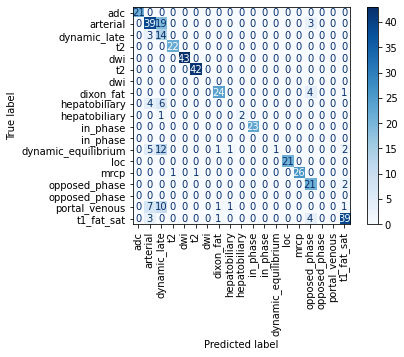

<Figure size 1800x1800 with 0 Axes>

In [16]:
f = display_and_save_results(meta_test_results_df, fn='meta')


Preprocessing metadata for Random Forest classifier.
Have received 432 entries.
accuracy is 0.7685185185185185
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.62      0.64      0.63        61
           6       0.22      0.82      0.35        17
           7       0.96      1.00      0.98        22
           8       1.00      1.00      1.00        43
           9       0.98      1.00      0.99        42
          11       0.89      0.83      0.86        29
          12       0.00      0.00      0.00        10
          13       1.00      0.67      0.80         3
          14       1.00      1.00      1.00        23
          16       1.00      0.05      0.09        22
          17       1.00      1.00      1.00        21
          18       1.00      0.93      0.96        28
          19       0.67      0.78      0.72        23
          23       0.00      0.00      0.00        20
          25       0.78 

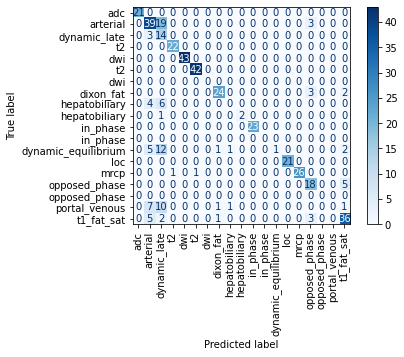

<Figure size 1800x1800 with 0 Axes>

In [18]:
## just checking to make sure the saved model is better than vanilla RF
vanilla_model = RandomForestClassifier(min_samples_leaf=2)
vanilla_model.fit(X_train_meta[feats_to_keep], y_train)
vanillapreds, vanillaprobs, vanillay, vanillaacc = meta_inference(test_df, vanilla_model, feats_to_keep)
print('accuracy is', vanillaacc)
vanilla_results_df = make_results_df(vanillapreds, vanillaprobs, TEy, test_df)
f= display_and_save_results(vanilla_results_df)


In [ ]:
### get inference from a single file

def meta_to_vector(filename)


It shows no significant change in the overall accuracy compared with the default parameters...

### Getting pixel inference results

In [279]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(pretrained=True) # Load the ResNet50 model 

# Replace the output layer to match the number of output units in your fine-tuned model
num_finetuned_output_units = 19
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, num_finetuned_output_units)

# Load the saved state_dict
state_dict = torch.load('../models/pixel_model_041623.pth', map_location=device)
model.load_state_dict(state_dict)

# Move the model to the appropriate device
model = model.to(device)  


In [260]:
def image_to_tensor(filepath):
    # Define the transformations to match the ones used during training/evaluation of the test dataset
#     test_transform = transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.Resize(299),
#         transforms.CenterCrop(299),
#         transforms.Grayscale(num_output_channels=3),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize the image using the same mean and std values as during training
# ])

    # Load an image and apply the transformations
    #image = Image.open(filepath)
    ds = pydicom.dcmread(filepath)
    img = np.array(ds.pixel_array, dtype=np.float32)
    img = img[np.newaxis]
    img = torch.from_numpy(np.asarray(img))
    input_tensor = data_transforms['test'](img)

    # Add a batch dimension to the input tensor
    input_tensor = input_tensor.unsqueeze(0)
    print('changing input_tensor to shape', input_tensor.shape)
    # Move the input tensor to the appropriate device
    input_tensor = input_tensor.to(device)

    return input_tensor




In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def get_pixel_preds_and_probs(model, filelist, classes=classes, device=device):
    model = model.to(device)
    # Turn autograd off
    with torch.no_grad():
        model.eval()

    preds = []
    probs = []
    
    count = 0
    for file in filelist:
        #print('on item ', count, file)
        
        each_tensor = image_to_tensor(file)
        #visualization of a batch of images
        each_tensor = each_tensor.to(device)
        # Feed inputs through model to get raw scores
        logits = model.forward(each_tensor)
        
        
        prob = torch.softmax(logits, dim=1)
        prob = prob.detach().cpu().numpy()
        #print(labels, probs)
        # Get discrete predictions using argmax
        pred = classes[np.argmax(prob)]
        # Add predictions and actuals to lists
        preds.append(pred)
        probs.append(prob)
        
       
        # logits = model.forward(each_tensor)
        # # Convert the output to a desired format 
        # output_numpy = output.detach().numpy()
        
        # # Apply the softmax function to convert logits to probabilities
        # probabilities = np.exp(output_numpy) / np.sum(np.exp(output_numpy), axis=1, keepdims=True)

        # # Find the class predictions
        # pred = classes[np.argmax(probabilities, axis=1)]
        # print('predicted class is ', pred)
        # # Store probabilities and predictions
        # probs.append(probabilities)
        # preds.append(pred)

        count+= 1
    # Convert lists to numpy arrays
    predictions_array = np.array(preds).flatten()
    probabilities_array = np.array(probs).squeeze()

    # Print the predictions and probabilities arrays
    #print("Predictions array:", predictions_array)
    #print("Probabilities array:", probabilities_array)


    return predictions_array, probabilities_array



In [32]:
pixel_train_preds, pixel_train_probs = get_pixel_preds_and_probs(model, train_df.fname.tolist())
pixel_val_preds, pixel_val_probs = get_pixel_preds_and_probs(model, val_df.fname.to_list())
pixel_test_preds, pixel_test_probs = get_pixel_preds_and_probs(model, test_df.fname.to_list())

NameError: name 'model' is not defined

In [282]:
pixel_train_results_df = make_results_df(pixel_train_preds, pixel_train_probs, Ty, train_df)
pixel_val_results_df = make_results_df(pixel_val_preds, pixel_val_probs, Vy, val_df)
pixel_test_results_df = make_results_df(pixel_test_preds, pixel_test_probs, TEy, test_df)
pixel_test_results_df

,preds,true,probs,patientID,series_description,contrast,plane
0,8,8,"[5.295005848893197e-06, 2.5784959234442795e-06, 1.871971335276612e-06, 2.8697016318801616e-07, 0.9995385408401489, 0.0004020421765744686, 1.518843987469154e-06, 8.767859981162474e-06, 2.662447968759807e-06, 4.322704626247287e-06, 1.3077354878987535e-06, 8.256866408373753e-07, 3.3850503768917406e-06, 3.85517205359065e-06, 1.1364853889972437e-05, 3.017984681719099e-06, 9.718829687699326e-07, 5.70565191537753e-07, 6.8958347583247814e-06]",102,ax diff_TRACEW,1,ax
1,8,8,"[7.795669262122829e-06, 3.77051804889561e-07, 1.3306873825058574e-06, 5.689631734639988e-07, 0.999536395072937, 0.00036113738315179944, 1.920655677167815e-06, 3.905836820194963e-06, 2.2699914552504197e-06, 3.9697292777418625e-06, 5.590991349890828e-06, 9.76624164650275e-07, 6.624837169511011e-06, 4.107923359697452e-06, 1.0245211342407856e-05, 1.4333796571008861e-05, 9.867979997579823e-07, 6.653008313151076e-07, 3.680178997456096e-05]",102,ax diff_TRACEW,1,ax
2,23,16,"[1.4107871720625553e-05, 0.009412507526576519, 0.00028372410451993346, 1.1474519851617515e-05, 3.0204287213564385e-06, 8.30375574878417e-05, 2.617202335386537e-05, 0.0008685443317517638, 0.441728800535202, 0.0008089017355814576, 7.562090900137264e-07, 1.7238096916116774e-05, 0.007698968984186649, 6.642098355769122e-07, 0.00042543112067505717, 1.4503935744869523e-05, 2.8027006919728592e-05, 0.530772864818573, 0.007801275234669447]",102,ax equilibrium new,1,ax
3,2,2,"[5.122976654092781e-05, 0.9612749218940735, 0.00028168284916318953, 2.5572693630238064e-05, 0.00013175696949474514, 0.00037823524326086044, 0.00011051096953451633, 9.951912943506613e-05, 0.0015253808815032244, 0.0005295698647387326, 2.1635914890794083e-05, 5.7667162764118984e-05, 0.0008997833356261253, 0.00018510794325266033, 0.00010140341328224167, 0.0005109807825647295, 5.242304541752674e-05, 0.01592467725276947, 0.017837945371866226]",102,ax dyn new,1,ax
4,25,25,"[1.6286387563013704e-06, 0.002541319001466036, 1.7130394098785473e-06, 9.334833066532155e-07, 5.632040938507998e-06, 2.3475324269384146e-05, 3.28775126945402e-06, 1.3577317076851614e-05, 0.0001314869150519371, 1.2296535714995116e-05, 1.4450525668507908e-05, 1.3575264574683388e-06, 3.3449955481046345e-06, 7.983420800883323e-06, 4.035400706925429e-06, 4.4944084947928786e-05, 1.6027393030526582e-06, 1.5534296835539863e-06, 0.9971852898597717]",102,ax dixon_W,0,ax
...,...,...,...,...,...,...,...
427,8,8,"[1.6788677385193296e-05, 0.00011456928768893704, 1.9850658645736985e-06, 3.967888915212825e-06, 0.9995980858802795, 4.174047717242502e-05, 9.187433533952571e-06, 2.227090772066731e-05, 6.412235507013975e-06, 9.538634913042188e-06, 3.111479236395098e-05, 3.107758857368026e-06, 9.542838597553782e-06, 4.525854819803499e-05, 2.0366482203826308e-05, 1.3505541573977098e-05, 3.545582558217575e-06, 5.048510047345189e-06, 4.406617517815903e-05]",58,ax diff_TRACEW,1,ax
428,7,7,"[3.0261264782893704e-07, 1.492674925884785e-07, 0.0001412155106663704, 0.9997287392616272, 1.1134382020827616e-06, 6.25413986199419e-06, 1.1435249689384364e-06, 6.164690375953796e-07, 1.7378543759605236e-07, 6.320663669612259e-05, 1.9821477792447695e-07, 1.0693768217606703e-06, 1.7542804471304407e-06, 1.3705421224585734e-05, 3.6155321140540764e-05, 4.974012881575618e-07, 1.4771662790735718e-06, 2.2252957023738418e-06, 4.588561353102705e-08]",58,cor haste,0,cor
429,2,2,"[2.230612778930663e-07, 0.9993759989738464, 1.0432645467517432e-06, 5.670335667673498e-07, 8.22177480586106e-06, 3.0397495720535517e-07, 7.4195304478053e-07, 1.5606404986101552e-06, 1.2802860510419123e-05, 2.1537227894441457e-06, 7.94997632169725e-08, 3.0443973741967056e-07, 3.5043504453824426e-07, 3.989436663687229e-06, 1.0598745348033844e-06, 2.1934654341748683e-06, 2.689691029900132e-07, 3.9294016460189596e-05, 0.000548851618077606]",58,ax dyn new,1,ax
430,14,14,"[1.3646952083945507e-06, 7.470232503692387e-06, 2.162862777765895e-08, 4.809397069038823e-06, 1.2431326467776671e-05, 3.276

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.77      0.79      0.78        61
           6       0.81      1.00      0.89        17
           7       1.00      0.91      0.95        22
           8       0.96      1.00      0.98        43
           9       1.00      0.95      0.98        42
          11       1.00      1.00      1.00        29
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00         3
          14       0.88      0.96      0.92        23
          16       0.80      0.36      0.50        22
          17       0.95      0.95      0.95        21
          18       1.00      1.00      1.00        28
          19       0.88      0.96      0.92        23
          23       0.39      0.65      0.49        20
          25       0.83      0.91      0.87        47

    accuracy                           0.87       432
   macro avg       0.77   

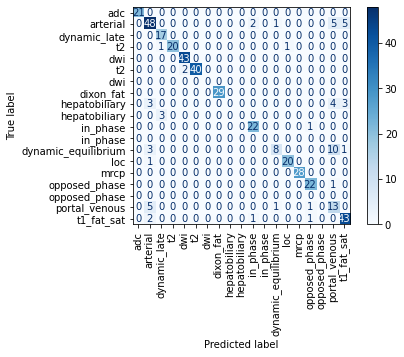

<Figure size 1800x1800 with 0 Axes>

In [ ]:
f = display_and_save_results(pixel_test_results_df, fn='pixel')

### Getting NLP inference


In [9]:
# Load the pickled model
with open('../models/text_model20230415.st', 'rb') as file:
    NLP_model = pickle.load(file)

In [124]:
!pip install sentence_transformers

  Using cached sentence_transformers-2.2.2-py3-none-any.whl
     |████████████████████████████████| 7.0 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 200 kB 4.0 MB/s eta 0:00:01
  Using cached tokenizers-0.13.3-cp38-cp38-macosx_10_11_x86_64.whl (4.0 MB)
  Using cached torch-1.7.1-cp38-none-macosx_10_9_x86_64.whl (108.9 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
monai 1.1.0 requires torch>=1.8, but you have torch 1.7.1 which is incompatible.


In [209]:
train_preds, train_acc, val_preds, val_acc, test_preds, test_acc, text_model_T = train_text_log_model(train_df, val_df, test_df, senttrans_model=sentence_encoder)
print(train_acc, val_acc, test_acc)

NameError: name 'train_text_log_model' is not defined

In [241]:

nlp_test_preds, nlp_test_probs = get_NLP_inference(NLP_model, test.file_info.tolist())
nlp_train_preds, nlp_train_probs = get_NLP_inference(NLP_model, train.file_info.tolist())
nlp_val_preds, nlp_val_probs = get_NLP_inference(NLP_model, val.file_info.tolist())


2023-04-15 23:10:37,604 - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches: 100%|██████████| 1/1 [00:00<00:00, 21.97it/s]


2023-04-15 23:10:48,057 - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches: 100%|██████████| 1/1 [00:00<00:00, 91.22it/s]


2023-04-15 23:11:25,423 - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches: 100%|██████████| 1/1 [00:00<00:00, 87.29it/s]


In [242]:
print(classification_report(nlp_test_preds, TEy))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.98      0.95      0.97        63
           6       1.00      0.85      0.92        20
           7       1.00      0.96      0.98        23
           8       1.00      1.00      1.00        43
           9       1.00      1.00      1.00        42
          11       0.86      1.00      0.93        25
          12       0.60      1.00      0.75         6
          13       0.00      0.00      0.00         0
          14       1.00      1.00      1.00        23
          16       1.00      0.81      0.90        27
          17       1.00      1.00      1.00        21
          18       0.96      1.00      0.98        27
          19       1.00      1.00      1.00        23
          23       1.00      0.91      0.95        22
          25       0.94      0.96      0.95        46

    accuracy                           0.96       432
   macro avg       0.90   

In [275]:
nlp_train_results_df = make_results_df(nlp_train_preds, nlp_train_probs, Ty, train_df)
nlp_val_results_df = make_results_df(nlp_val_preds, nlp_val_probs, Vy, val_df)
nlp_test_results_df = make_results_df(nlp_test_preds, nlp_test_probs, TEy, test_df)

#change names of preds, probs 
for frame_df in [nlp_train_results_df, nlp_val_results_df, nlp_test_results_df]:
    frame_df.rename(columns={'preds':'nlp_preds', 'probs':'nlp_probs'}, inplace=True)


In [243]:
print(meta_vector.shape)
print(nlp_train_probs.shape)

(1369, 19)
(1369, 19)


In [283]:
#change names of preds, probs 
for frame_df in [nlp_train_results_df, nlp_val_results_df, nlp_test_results_df]:
    frame_df.rename(columns={'preds':'nlp_preds', 'probs':'nlp_probs'}, inplace=True)

for frame_df in [pixel_train_results_df, pixel_val_results_df, pixel_test_results_df]:
    frame_df.rename(columns={'preds':'pixel_preds', 'probs':'pixel_probs'}, inplace=True)

for frame_df in [meta_train_results_df, meta_val_results_df, meta_test_results_df]:
    frame_df.rename(columns={'preds':'meta_preds', 'probs':'meta_probs'}, inplace=True)


In [276]:
nlp_train_results_df

,nlp_preds,true,nlp_probs,patientID,series_description,contrast,plane
0,8,8,"[0.020583117219662772, 0.010903398861520041, 0.0009219695432471948, 0.001186827366113606, 0.8919651283538699, 0.023230189183809247, 0.0003882503184114099, 0.01115494172376811, 0.0026917216997651666, 0.0008547114874260082, 0.005626948501018502, 0.0003480571803900264, 0.004635548008826763, 0.002395440110027482, 0.002171796117076895, 0.007222901655572152, 0.00034788598859700095, 0.0038803619170794737, 0.009490804763818377]",104,ax diff_TRACEW,1,ax
1,8,8,"[0.020583117219662772, 0.010903398861520041, 0.0009219695432471948, 0.001186827366113606, 0.8919651283538699, 0.023230189183809247, 0.0003882503184114099, 0.01115494172376811, 0.0026917216997651666, 0.0008547114874260082, 0.005626948501018502, 0.0003480571803900264, 0.004635548008826763, 0.002395440110027482, 0.002171796117076895, 0.007222901655572152, 0.00034788598859700095, 0.0038803619170794737, 0.009490804763818377]",104,ax diff_TRACEW,1,ax
2,16,16,"[0.01010469118565345, 0.023720291059151646, 0.004030169855110401, 0.001347889236481563, 0.011807272878532152, 0.014338979151129886, 0.0005932208909441949, 0.009543675821096585, 0.05088408064135952, 0.0014002964901355017, 0.014362836710930965, 0.0005589913858506072, 0.8214210065712495, 0.0029564122952476218, 0.0032360335551993714, 0.013837046538673212, 0.0005586499437811647, 0.0049143071961676756, 0.010384148593304906]",104,ax equilibrium,1,ax
3,9,9,"[0.0039728347363059335, 0.019522594690295707, 0.0010197881640822504, 0.03267967259349544, 0.014201617186241846, 0.8462729524817577, 0.0005360883989073814, 0.008939240000892974, 0.0070209569100812465, 0.0015223888093356828, 0.00710972239320416, 0.00048244093576063683, 0.008957167104852802, 0.0045709066735545355, 0.004436229159897466, 0.013933156692688072, 0.0004822132489213859, 0.0031726982623664995, 0.021167331557358178]",104,ax haste bh,0,ax
4,9,9,"[0.003472503061260259, 0.03219529767313347, 0.0017616833067022302, 0.003672367705924062, 0.00551147692550676, 0.8604031941309591, 0.0005309839542261958, 0.005270856093956967, 0.009789627710467645, 0.0017003358180711213, 0.011472254285126394, 0.0005350483189568019, 0.019322467931167587, 0.00495552459279312, 0.002925614290447279, 0.007942840426588953, 0.0005347404098390428, 0.010474216170399448, 0.017528967194473298]",104,ax t2 triggerred,0,ax
...,...,...,...,...,...,...,...
1364,7,7,"[0.003252560130699739, 0.0031161803698984457, 0.01831369930741385, 0.8857675098692731, 0.0026684604189672434, 0.03269827722843454, 0.0005045973654945132, 0.00657987939998691, 0.0032648293591570113, 0.006040759635718784, 0.0035678892075413373, 0.0005262891146806475, 0.002871634080833943, 0.006248476903380838, 0.017164629571199477, 0.002889678846086592, 0.000525956235356522, 0.0012955185159490806, 0.0027031744399274166]",94,cor haste,0,cor
1365,2,2,"[0.0034046553189864643, 0.8864598534885728, 0.0008614905978988318, 0.0015838358425279496, 0.02173277117665408, 0.016188192533002115, 0.0003466413303544453, 0.006033969172978267, 0.003786531387991924, 0.0007837668910371759, 0.006199507125539789, 0.0003014793695639799, 0.006398241017094551, 0.002482936728156599, 0.0009927957571013142, 0.004802418087697059, 0.0003013418163426731, 0.006647817003252835, 0.03069175535524732]",94,ax dyn,1,ax
1366,2,2,"[0.0034046553189864643, 0.8864598534885728, 0.0008614905978988318, 0.0015838358425279496, 0.02173277117665408, 0.016188192533002115, 0.0003466413303544453, 0.006033969172978267, 0.003786531387991924, 0.0007837668910371759, 0.006199507125539789, 0.0003014793695639799, 0.006398241017094551, 0.002482936728156599, 0.0009927957571013142, 0.004802418087697059, 0.0003013418163426731, 0.006647817003252835, 0.03069175535524732]",94,ax dyn,1,ax
1367,19,19,"[0.00793388330092357, 0.00959295807354836, 0.001450327077547432, 0.002463043658793659, 0.008871400939086572, 0.012651862440695326, 0.0006224698348205704, 0.05408493598361225, 0.006304421262380375, 0.0014741811232536766, 0.05490965250600963, 0.000612350040818815

In [244]:


# def load_text_data2(train_csv, val_csv, test_csv):
    
#     train_df = pd.read_csv(train_csv)
#     val_df = pd.read_csv(val_csv)
#     test_df = pd.read_csv(test_csv)
    
#     # #run once at start to rid unneccesary column
#     # train_csv.drop('Unnamed: 0', axis=1, inplace=True)
#     # test_csv.drop('Unnamed: 0', axis=1, inplace=True)

#     #train_df = pd.read_pickle(train_file)
#     #test_df = pd.read_pickle(test_file)
#     #print('val list:', val_list)
#     #val_df = train_df[train_df.patientID.isin(val_list)]
#     #train_df = train_df[~train_df.index.isin(val_df.index)]

#     #train_df = train_df.reset_index(drop=True)
#     #val_df = val_df.reset_index(drop=True)
#     #test_df = test_df.reset_index(drop=True)

#     # # create shortened dataframes for train and test
#     # train_df_short = shorten_df(train_df, selection_fraction = 0.5)
#     # test_df_short = shorten_df(test_df, selection_fraction = 0.5)

#     # # create train, val, test datasets
#     # val = train_df_short[train_df_short.patientID.isin(val_list)].reset_index(drop=True)
#     # train = train_df_short[~train_df_short.index.isin(val.index)].reset_index(drop=True)
#     # test = test_df_short.reset_index(drop=True)

#     # train = train_df.reset_index(drop=True)
#     # val = val_df.reset_index(drop=True)
#     # test = test_df.reset_index(drop=True)
#     #print(train_df.columns)
#     train_df = shorten_df(train_df)
#     val_df = shorten_df(val_df)
#     test_df = shorten_df(test_df)

#     train_df = prepare_df(train_df)
#     val_df = prepare_df(val_df)
#     test_df = prepare_df(test_df)



#     return train_df, val_df, test_df


# senttrans_model = SentenceTransformer(sentence_encoder, device=device)

# # now accepts dataframes instead
# def train_text_log_model2(train_data, val_data, test_data, senttrans_model=senttrans_model):
#     print('getting the text from the column', series_description_column)
#     #print(sentence_encoder)
#     X_train = train_data[series_description_column]
#     y_train = train_data['label']
#     #print(X_train.to_list())
#     X_val = val_data[series_description_column]
#     y_val = val_data['label']
#     # print('shape of X_val, y_val is :', X_val.shape, y_val.shape)

#     X_test = test_data[series_description_column]
#     y_test = test_data['label']

#     #encode the text labels in the train, val, and test datasets
#     X_train_encoded = [senttrans_model.encode(doc) for doc in X_train.to_list()]
#     print(X_train_encoded[0].shape)
#     X_val_encoded = [senttrans_model.encode(doc) for doc in X_val.to_list()]
#     X_test_encoded = [senttrans_model.encode(doc) for doc in X_test.to_list()]

#     # Train a classification model using logistic regression classifier
#     logreg_model = LogisticRegression(solver='saga')
#     logreg_model.fit(X_train_encoded, y_train)
    
#     train_preds = logreg_model.predict(X_train_encoded)
#     train_probs = logreg_model.predict_proba(X_train_encoded)
#     train_acc = sum(train_preds == y_train) / len(y_train)
#     print('Accuracy on the training set is {:.3f}'.format(train_acc))

#     ## assess on the val set
#     print('size of X_val_encoded is ', len(X_val_encoded))
#     print('size of y_val is ', len(y_val))
#     val_preds = logreg_model.predict(X_val_encoded)
#     val_probs = logreg_model.predict_proba(X_val_encoded)
#     print('size of preds_val is ', len(val_preds))
#     val_acc = sum(val_preds == y_val)/ len(y_val)
#     print('Accuracy on the val set is {:.3f}'.format(val_acc))
    
#     ## display results on test set
#     test_preds = logreg_model.predict(X_test_encoded)
#     test_probs = logreg_model.predict_proba(X_test_encoded)
#     test_acc = sum(test_preds == y_test) / len(y_test)
#     ## display results on test set
#     print('Accuracy on the test set is {:.3f}'.format(test_acc))


#     #export model
#     txt_model_filename = "../models/text_model"+ datetime.now().strftime('%Y%m%d') + ".st"
#     pickle.dump(logreg_model, open(txt_model_filename, 'wb'))

#     return train_preds, train_probs, train_acc, val_preds, val_probs, val_acc, test_preds, test_probs, test_acc, logreg_model




# def list_incorrect_text_predictions2(ytrue, ypreds, series_desc):
#     ytrue = ytrue.tolist()
#     ytrue_label = [abd_label_dict[str(x)]['short'] for x in ytrue]
#     ypreds = ypreds.tolist()
#     ypreds_label = [abd_label_dict[str(x)]['short'] for x in ypreds]
#     ylist = zip(series_desc, ytrue, ypreds)
#     ylist_label = zip(series_desc,ytrue_label, ypreds_label)
#     y_incorrect_list = [x for x in ylist if x[1]!=x[2]]
#     y_incorrect_list_label = [x for x in ylist_label if x[1]!=x[2]]
#     return y_incorrect_list, y_incorrect_list_label

# ## test
# ## csv files
# train_datafile = '../data/trainfiles.csv'
# test_datafile = '../data/testfiles.csv'
# val_datafile = '../data/valfiles.csv'

# train_data, val_data, test_data = load_text_data2(train_datafile, val_datafile, test_datafile)
# train_preds, train_probs, train_acc, val_preds, val_probs, val_acc, test_preds, test_probs, test_acc, logreg_model = train_text_log_model2(train_data, val_data, test_data)
# print(test_preds, test_acc)
# # list, list_label = list_incorrect_text_predictions(y_test, preds_test, series_desc)
# # print(list_label)


## Create fusion model

In [430]:
fusion_train_df = pixel_train_results_df.copy()
fusion_train_df[['meta_preds', 'meta_probs']] = meta_train_results_df[['meta_preds', 'meta_probs']]
fusion_train_df[['nlp_preds', 'nlp_probs']] = nlp_train_results_df[['nlp_preds', 'nlp_probs']]


In [428]:
fusion_val_df = pixel_val_results_df.copy()
fusion_val_df[['meta_preds', 'meta_probs']] = meta_val_results_df[['meta_preds', 'meta_probs']]
fusion_val_df[['nlp_preds', 'nlp_probs']] = nlp_val_results_df[['nlp_preds', 'nlp_probs']]


In [429]:
fusion_test_df = pixel_test_results_df.copy()
fusion_test_df[['meta_preds', 'meta_probs']] = meta_test_results_df[['meta_preds', 'meta_probs']]
fusion_test_df[['nlp_preds', 'nlp_probs']] = nlp_test_results_df[['nlp_preds', 'nlp_probs']]


In [427]:
fusion_train_df.to_pickle('../data/fusion_train.pkl')
fusion_val_df.to_pickle('../data/fusion_val.pkl')
fusion_test_df.to_pickle('../data/fusion_test.pkl')


In [433]:
Xtrain1 = fusion_train_df.meta_probs.values

Xtrain2 = fusion_train_df.pixel_probs.values
Xtrain3 = fusion_train_df.nlp_probs.values

Xtrain1 = np.stack(Xtrain1, axis=0)
Xtrain2 = np.stack(Xtrain2, axis=0)
Xtrain3 = np.stack(Xtrain3, axis=0)

out_features = 19

actual_classes = [0,2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,23,25]
y_train_fusion = np.array([actual_classes.index(x) for x in fusion_train_df.true])


In [35]:
class FusionModel(nn.Module):
    def __init__(self, model1, model2, model3, num_classes):
        super(FusionModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.fusion_layer = nn.Linear(num_classes * 3, num_classes)

    def forward(self, x1, x2, x3):
        
        x = torch.cat((x1, x2, x3), dim=1)
        x = self.fusion_layer(x)

        return x

In [36]:
class PartialFusionModel(nn.Module):
    def __init__(self, model1, model2, num_classes):
        super(PartialFusionModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        #self.model3 = model3
        self.fusion_layer = nn.Linear(num_classes * 2, num_classes)

    def forward(self, x1, x2):
        
        x = torch.cat((x1, x2), dim=1)
        x = self.fusion_layer(x)

        return x

In [435]:
num_classes = 19  # Number of classes
pixel_model = model
fusion_model = FusionModel(meta_model, pixel_model, NLP_model, num_classes)
meta_and_pixel_fusion_model = PartialFusionModel(meta_model, pixel_model, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=0.001)
p_optimizer = torch.optim.Adam(meta_and_pixel_fusion_model.parameters(), lr=0.001)

In [436]:
num_epochs = 20
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(y_train_fusion), batch_size):
        actual_batch_size = min(batch_size, len(Xtrain1) - i)
        X1_batch = torch.tensor(np.array(Xtrain1[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
        X2_batch = torch.tensor(np.array(Xtrain2[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
        X3_batch = torch.tensor(np.array(Xtrain3[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
        y_batch = torch.tensor(y_train_fusion[i:i+actual_batch_size], dtype=torch.long)

        # print(f"X1_batch shape: {X1_batch.shape}")
        # print(f"X2_batch shape: {X2_batch.shape}")
        # print(f"X3_batch shape: {X3_batch.shape}")
        # print(f"y_batch shape: {y_batch.shape}")


        optimizer.zero_grad()
        outputs = fusion_model(X1_batch, X2_batch, X3_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


Epoch [1/20], Loss: 2.7594962120056152
Epoch [2/20], Loss: 2.549872636795044
Epoch [3/20], Loss: 2.347651481628418
Epoch [4/20], Loss: 2.153589963912964
Epoch [5/20], Loss: 1.9685009717941284
Epoch [6/20], Loss: 1.793197512626648
Epoch [7/20], Loss: 1.6284205913543701
Epoch [8/20], Loss: 1.4747648239135742
Epoch [9/20], Loss: 1.3326175212860107
Epoch [10/20], Loss: 1.202121615409851
Epoch [11/20], Loss: 1.0831702947616577
Epoch [12/20], Loss: 0.9754281640052795
Epoch [13/20], Loss: 0.8783715963363647
Epoch [14/20], Loss: 0.7913391590118408
Epoch [15/20], Loss: 0.7135814428329468
Epoch [16/20], Loss: 0.6443043351173401
Epoch [17/20], Loss: 0.5827059149742126
Epoch [18/20], Loss: 0.5280027985572815
Epoch [19/20], Loss: 0.4794508218765259
Epoch [20/20], Loss: 0.4363558888435364


In [437]:
Xtest1 = fusion_test_df.meta_probs.values
Xtest2 = fusion_test_df.pixel_probs.values
Xtest3 = fusion_test_df.nlp_probs.values

Xtest1 = np.stack(Xtest1, axis=0)
Xtest2 = np.stack(Xtest2, axis=0)
Xtest3 = np.stack(Xtest3, axis=0)

out_features = 19

actual_classes = [0,2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,23,25]
y_test_fusion = np.array([actual_classes.index(x) for x in fusion_test_df.true])

In [438]:
print(Xtest1.shape, Xtest2.shape, Xtest3.shape, y_test_fusion.shape)

(432, 19) (432, 19) (432, 19) (432,)


In [439]:
import torch.nn.functional as F
# Evaluate the model with the test data
with torch.no_grad():
    X1_test_t = torch.tensor(Xtest1, dtype=torch.float32)
    X2_test_t = torch.tensor(Xtest2, dtype=torch.float32)
    X3_test_t = torch.tensor(Xtest3, dtype=torch.float32)
    y_test_t = torch.tensor(y_test_fusion, dtype=torch.long)

    outputs = fusion_model(X1_test_t, X2_test_t, X3_test_t)
    f_probabilities = F.softmax(outputs, dim=1)  # Apply softmax to the outputs

    _, f_predicted = torch.max(outputs, 1)
    correct = (f_predicted == y_test_t).sum().item()
    f_accuracy = correct / len(y_test_t) * 100

print(f'Test accuracy: {f_accuracy}%')

Test accuracy: 94.21296296296296%


In [440]:
fusion_test_results_df = make_results_df(f_predicted, f_probabilities, y_test_t, test_df)

In [442]:
fusion_test_results_df

,preds,true,probs,patientID,series_description,contrast,plane
0,4,4,"[0.021396970376372337, 0.020487060770392418, 0.01766064763069153, 0.016244331374764442, 0.7125632166862488, 0.02500881254673004, 0.008918930776417255, 0.01569932885468006, 0.011324414052069187, 0.010730977170169353, 0.018159355968236923, 0.009191839955747128, 0.01639493927359581, 0.017215007916092873, 0.015577628277242184, 0.01548106037080288, 0.008368594571948051, 0.014795802533626556, 0.0247811246663332]",102,ax diff_TRACEW,1,ax
1,4,4,"[0.021397162228822708, 0.020487036556005478, 0.01766066811978817, 0.016244489699602127, 0.7125626802444458, 0.025007683783769608, 0.008918950334191322, 0.015699153766036034, 0.011324497871100903, 0.010731030255556107, 0.018159449100494385, 0.009191898629069328, 0.01639495976269245, 0.017214927822351456, 0.015577542595565319, 0.015481228940188885, 0.00836863648146391, 0.014795891009271145, 0.024782059714198112]",102,ax diff_TRACEW,1,ax
2,12,12,"[0.03269666060805321, 0.08453246206045151, 0.060602132230997086, 0.030212001875042915, 0.04324795678257942, 0.030636470764875412, 0.01764671504497528, 0.035457029938697815, 0.0795121043920517, 0.025039667263627052, 0.03837970271706581, 0.021747229620814323, 0.21100939810276031, 0.02996177226305008, 0.03609180077910423, 0.03974157199263573, 0.01975918561220169, 0.11220285296440125, 0.05152327939867973]",102,ax equilibrium new,1,ax
3,1,1,"[0.02039298415184021, 0.5785853266716003, 0.03681271895766258, 0.019540918990969658, 0.02806386910378933, 0.01975311152637005, 0.011304709129035473, 0.02205103076994419, 0.01842307671904564, 0.016115963459014893, 0.023295851424336433, 0.012619994580745697, 0.04500898718833923, 0.016525454819202423, 0.018567394465208054, 0.019664593040943146, 0.009975509718060493, 0.03656923398375511, 0.04672933742403984]",102,ax dyn new,1,ax
4,18,18,"[0.017389634624123573, 0.029795730486512184, 0.015073947608470917, 0.014224188402295113, 0.016708897426724434, 0.02010926604270935, 0.007709000259637833, 0.03563356399536133, 0.013885191641747952, 0.011900950223207474, 0.026158053427934647, 0.010085373185575008, 0.026317624375224113, 0.012767169624567032, 0.016225390136241913, 0.025503454729914665, 0.010427834466099739, 0.0187054593116045, 0.6713792085647583]",102,ax dixon_W,0,ax
...,...,...,...,...,...,...,...
427,4,4,"[0.022166727110743523, 0.020634325221180916, 0.017857089638710022, 0.016359593719244003, 0.7091633081436157, 0.02528732270002365, 0.008946101181209087, 0.01592734083533287, 0.01145593449473381, 0.01082950085401535, 0.018338656052947044, 0.009312472306191921, 0.016540363430976868, 0.01737906225025654, 0.015780674293637276, 0.015640340745449066, 0.00847703218460083, 0.014933442696928978, 0.024970654398202896]",58,ax diff_TRACEW,1,ax
428,3,3,"[0.017113015055656433, 0.02521120384335518, 0.019466958940029144, 0.6469280123710632, 0.029334161430597305, 0.03610522300004959, 0.011684862896800041, 0.018022747710347176, 0.01232165191322565, 0.014737758785486221, 0.019595030695199966, 0.014695871621370316, 0.017463382333517075, 0.02003064751625061, 0.026205332949757576, 0.01591380499303341, 0.014797412790358067, 0.017077220603823662, 0.02329569309949875]",58,cor haste,0,cor
429,1,1,"[0.01968565583229065, 0.5951127409934998, 0.035550929605960846, 0.018941828981041908, 0.026989372447133064, 0.01902218908071518, 0.010984986089169979, 0.02135545201599598, 0.017756065353751183, 0.015551040880382061, 0.022536177188158035, 0.012176945805549622, 0.04340915009379387, 0.01599057763814926, 0.017903372645378113, 0.018967652693390846, 0.009568898007273674, 0.03434310853481293, 0.044153790920972824]",58,ax dyn new,1,ax
430,10,10,"[0.021211950108408928, 0.029626861214637756, 0.021532874554395676, 0.018517808988690376, 0.028557738289237022, 0.026943741366267204, 0.010752583853900433, 0.04960396885871887, 0.018314946442842484, 0.01564510352909565, 0.4975303113460541, 0.014475567266345024, 0.025694185867905617, 0.01867469772696495, 0.027210615575313568, 0.08171723783016205, 0.013944628648

In [450]:
num_epochs = 20
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(y_train_fusion), batch_size):
        actual_batch_size = min(batch_size, len(Xtrain1) - i)
        X1_batch = torch.tensor(np.array(Xtrain1[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
        X2_batch = torch.tensor(np.array(Xtrain2[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
        #X3_batch = torch.tensor(np.array(Xtrain3[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
        y_batch = torch.tensor(y_train_fusion[i:i+actual_batch_size], dtype=torch.long)

        # print(f"X1_batch shape: {X1_batch.shape}")
        # print(f"X2_batch shape: {X2_batch.shape}")
        # print(f"X3_batch shape: {X3_batch.shape}")
        # print(f"y_batch shape: {y_batch.shape}")


        p_optimizer.zero_grad()
        outputs = meta_and_pixel_fusion_model(X1_batch, X2_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        p_optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


Epoch [1/20], Loss: 2.8027234077453613
Epoch [2/20], Loss: 2.6482958793640137
Epoch [3/20], Loss: 2.4979474544525146
Epoch [4/20], Loss: 2.3518826961517334
Epoch [5/20], Loss: 2.210340976715088
Epoch [6/20], Loss: 2.0735793113708496
Epoch [7/20], Loss: 1.9418646097183228
Epoch [8/20], Loss: 1.8154579401016235
Epoch [9/20], Loss: 1.6946020126342773
Epoch [10/20], Loss: 1.579504370689392
Epoch [11/20], Loss: 1.4703285694122314
Epoch [12/20], Loss: 1.3671813011169434
Epoch [13/20], Loss: 1.2701077461242676
Epoch [14/20], Loss: 1.1790897846221924
Epoch [15/20], Loss: 1.0940468311309814
Epoch [16/20], Loss: 1.014840841293335
Epoch [17/20], Loss: 0.9412838220596313
Epoch [18/20], Loss: 0.8731458187103271
Epoch [19/20], Loss: 0.8101656436920166
Epoch [20/20], Loss: 0.7520594596862793


In [451]:
import torch.nn.functional as F
# Evaluate the model with the test data
with torch.no_grad():
    X1_test_t = torch.tensor(Xtest1, dtype=torch.float32)
    X2_test_t = torch.tensor(Xtest2, dtype=torch.float32)
    #X3_test_t = torch.tensor(Xtest3, dtype=torch.float32)
    y_test_t = torch.tensor(y_test_fusion, dtype=torch.long)

    outputs = meta_and_pixel_fusion_model(X1_test_t, X2_test_t)
    g_probabilities = F.softmax(outputs, dim=1)  # Apply softmax to the outputs

    _, g_predicted = torch.max(outputs, 1)
    correct = (g_predicted == y_test_t).sum().item()
    g_accuracy = correct / len(y_test_t) * 100

print(f'Test accuracy: {g_accuracy}%')

Test accuracy: 89.58333333333334%


In [455]:
# for classification report and CM:
# Move the tensor to the CPU if it's on the GPU
if g_predicted.is_cuda:
    g_predicted = g_predicted.cpu()
g_predicted_list = g_predicted.tolist()
g_predictions = [classes[g] for g in g_predicted_list]


In [486]:
label_list = [abd_label_dict[str(x)]['short'] for x in actual_classes]
label_list

['adc',
 'arterial',
 'dynamic_late',
 't2',
 'dwi',
 't2',
 'dwi',
 'dixon_fat',
 'hepatobiliary',
 'hepatobiliary',
 'in_phase',
 'in_phase',
 'dynamic_equilibrium',
 'loc',
 'mrcp',
 'opposed_phase',
 'opposed_phase',
 'portal_venous',
 't1_fat_sat']

In [489]:
print(classification_report(g_predictions, TEy, labels = actual_classes, target_names = label_list))

                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        21
           arterial       0.93      0.78      0.85        73
       dynamic_late       1.00      0.85      0.92        20
                 t2       1.00      1.00      1.00        22
                dwi       1.00      1.00      1.00        43
                 t2       1.00      1.00      1.00        42
                dwi       0.00      0.00      0.00         0
          dixon_fat       0.97      1.00      0.98        28
      hepatobiliary       0.00      0.00      0.00         0
      hepatobiliary       0.00      0.00      0.00         0
           in_phase       0.91      0.95      0.93        22
           in_phase       0.00      0.00      0.00         0
dynamic_equilibrium       0.41      0.60      0.49        15
                loc       0.95      1.00      0.98        20
               mrcp       1.00      1.00      1.00        28
      opposed_phase    

In [476]:
actual_classes

[0, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 25]

In [480]:
def duplicated_cm_plot(ytrue, ypreds, classes, fname):
    
    cm = confusion_matrix(ytrue, ypreds, labels=classes)
    plt.figure(figsize=(25, 25))
    plt.tight_layout()
    ConfusionMatrixDisplay(cm, display_labels=[abd_label_dict[str(x)]['short'] for x in classes]).plot(xticks_rotation = 'vertical', cmap='Blues')
    plt.savefig(fname + datetime.now().strftime('%Y%m%d') + ".png", dpi=300, bbox_inches='tight')

    plt.show()

    return plt


<Figure size 1800x1800 with 0 Axes>

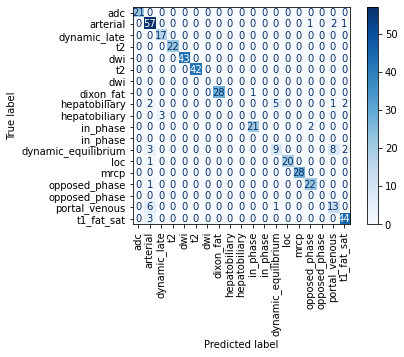

In [481]:
g_cm = duplicated_cm_plot(TEy,g_predictions, actual_classes, '../assets/figures/FigFusionMetaPixel')

In [491]:
# for classification report and CM:
# Move the tensor to the CPU if it's on the GPU
if f_predicted.is_cuda:
    f_predicted = f_predicted.cpu()
f_predicted_list = f_predicted.tolist()
f_predictions = [classes[f] for f in f_predicted_list]


<Figure size 1800x1800 with 0 Axes>

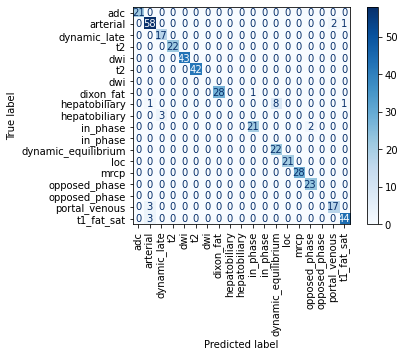

In [492]:
f_cm = duplicated_cm_plot(TEy,f_predictions, actual_classes, '../assets/figures/FigFusionAll')

In [493]:
# Save the trained fusion models to a file
with open('fusion_model041623.pkl', 'wb') as f:
    pickle.dump(fusion_model, f)

In [494]:
# Save the trained fusion models to a file
with open('meta_and_pixel_fusion_model041623.pkl', 'wb') as f:
    pickle.dump(meta_and_pixel_fusion_model, f)

# Inference fusion model

In [37]:
### load models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open('../models/text_model20230415.st', 'rb') as file:
    NLP_model = pickle.load(file)

with open('../models/meta_04152023.skl', 'rb') as file:
    meta_model = pickle.load(file)


with open('../models/fusion_model041623.pkl', 'rb') as file:
    fusion_model = pickle.load(file)

with open('../models/meta_and_pixel_fusion_model041623.pkl', 'rb') as file:
    fusion_model_part = pickle.load(file)

def load_pixel_model(modelpath, device=device, output_units = 19):
    
    model = models.resnet50(pretrained=True) # Load the ResNet50 model 

    # Replace the output layer to match the number of output units in your fine-tuned model
    num_finetuned_output_units = output_units
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, num_finetuned_output_units)

    # Load the saved state_dict
    state_dict = torch.load(modelpath, map_location=device)
    model.load_state_dict(state_dict)

    # Move the model to the appropriate device
    model = model.to(device)  

    return model

pixel_model = ('../models/pixel_model_041623.pth')



In [39]:

# ## this is more for inference of a single instance
# def extract_metadata(row, features = feats_to_keep):
#     ## assumes preprocessed, so just take the feature columns
#     result = row[features]
#     return result

# def extract_pixel_data(row):
#     return image_to_tensor(row.file_info)
    
# def extract_text_data(row):
#     return row.SeriesDescription
    


# def extract_data_for_models(row, features=feats_to_keep):
#     meta_data = extract_metadata(row, features)
#     pixel_data = extract_pixel_data(row)
#     text_data = extract_text_data(row)
#     return meta_data, pixel_data, text_data



def get_fusion_model_prediction(row, model1, model2, model3, fusion_model,device=device,features=feats_to_keep):
    #meta_data, pixel_data, text_data = extract_data_for_models(row)
    
    prob1 = get_meta_probs(row, model1, features)
    prob1_tensor = torch.tensor(prob1, dtype=torch.float32)
    
    _, prob2 = get_pixel_preds_and_probs(model2, [row.file_info], classes=classes)
    prob2_tensor = torch.tensor(prob2, dtype=torch.float32)

    _, prob3 = get_NLP_inference(model3, [row.file_info], device, classes=classes)
    prob3_tensor = torch.tensor(prob3, dtype=torch.float32)

    # Pass the tensors through the FusionModel
    fused_output = fusion_model(prob1_tensor, prob2_tensor, prob3_tensor)
    
    # Get the predicted class and confidence score
    predicted_class = classes[torch.argmax(fused_output, dim=1).item()]
    confidence_score = torch.max(torch.softmax(fused_output, dim=1)).item()
    
    return predicted_class, confidence_score

# Playing with writing results into DICOM metadata

In [ ]:
# fns = train.file_info.tolist()

# # Create an empty list to store the DICOM metadata
# data = []

# # Loop over the DICOM file names and extract the metadata
# for file_name in file_names:
#     # Read in the DICOM file
#     ds = pydicom.dcmread(file_name)
    
#     d = {}
#     for col in dicom_cols:
#         d.key = col
#         d.value = ds['col']
#     # Store the metadata in a dictionary
#     d = {
#         'patient_id': patient_id,
#         'study_date': study_date,
#         # ... add other metadata as needed ...
#     }
    
#     # Append the dictionary to the data list
#     data.append(d)

# # Create a DataFrame from the data list
# df = pd.DataFrame(data)
# This code reads in a list of DICOM file names, then loops over the files and extracts the metadata of interest using pydicom. It stores the metadata in a dictionary, then appends the dictionary to a list of dictionaries (data). Finally, it creates a Pandas DataFrame from the list of dictionaries using pd.DataFrame(data). You can modify this code to extract the specific metadata that you are interested in from your DICOM files.








In [194]:
full_train, full_val, full_test = load_text_data(train_datafile, val_datafile, test_datafile)
example_dicom_full = full_test[full_test.patientID==24]

NameError: name 'load_datasets_from_csv' is not defined

In [135]:
example_dicom_full

,file_info,label,patientID,series,img_num
1046,/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/32/0010.dcm,9,24,32,10
1047,/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/32/0004.dcm,9,24,32,4
1048,/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/32/0005.dcm,9,24,32,5
1049,/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/32/0011.dcm,9,24,32,11
1050,/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/32/0007.dcm,9,24,32,7
...,...,...,...,...,...
2808,/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/25/0034.dcm,25,24,25,34
2809,/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/25/0020.dcm,25,24,25,20
2810,/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/25/0021.dcm,25,24,25,21
2811,/volumes/cm7/Abdominal_MRI_dataset_split/test/024/exam1/25/0035.dcm,25,24,25,35


In [187]:

from pydicom.datadict import dictionary_VR
# Define the path where you want to save the DICOM file
save_path = '../data/modified/'
# Create the directory if it doesn't exist
if not os.path.exists(save_path):
    os.makedirs(save_path)

all_files_list = example_dicom_full.file_info.tolist()
all_labels_list = example_dicom_full.label.tolist()
for dicom_file, taglabel in zip(all_files_list, all_labels_list):
    ds = dcmread(dicom_file, no_pixels=False)
    #dictionary_VR([0x0011, 0x1010])
    
    #creator = pydicom.uid.generate_uid()
    # Define a new private tag for hanging protocol information
    tag = pydicom.tag.Tag(0x0011, 0x1010)
    tag2 = pydicom.tag.Tag(0x0011, 0x1011)
   
    
    value = taglabel
    value2 = 0.8
    data_element = pydicom.DataElement(tag, 'IS', value)
    data_element2 = pydicom.DataElement(tag2, 'DS', value2)
   
   
    #Add the new tags to a DICOM dataset
  
    ds.add(data_element)
    ds.add(data_element2)

    # # Create a new data element with the tag, value, and VR
    # value = taglabel
    # data_element = pydicom.DataElement(tag, value = taglabel, VR = 'IS')

    # Set the private creator identifier for the new tag
    #data_element.private_creator = creator

    #
    


    # Define the file name and path for the new DICOM file
    filefolder = '../data/modified/'+dicom_file.split('/')[-2]
    if not os.path.exists(filefolder):
        os.makedirs(filefolder)
    filename = dicom_file.split('/')[-1]
    filepath = os.path.join(filefolder, filename)

    # Save the dataset to a DICOM file
    ds.save_as(filepath)
    
    
    # tag = pydicom.datadict.tag_for_keyword('ML_type')
    # data_element = 
    # if tag is not None:
    #     # Create a new data element with the tag and value
    #     data_element = pydicom.DataElement(tag, value=str(taglabel))
    #     data_element.VR = 'SH'

    # # Add the new tag to the DICOM dataset
    # ds.add(data_element)

    # # tag2 = pydicom.datadict.tag_for_keyword('ML_certainty')
    # # data_element2 = pydicom.DataElement(tag2, value = 0.5, VR='SH')
   
    # # ds.add(data_element)
    # # ds.add(data_element2)

    # ds.save_as('/content/modifiedset/modified_'+dicom_file+'.dcm')



In [16]:

# def get_dicoms(path, first_dcm=False, **kwargs):
#     "Walk `path` to get DICOM file names from specific extensions, then read files into a `pandas.DataFrame`. If `first_dcm=True`, only read first file from each folder."
#     fns = L()
#     extension_list=['.dcm','.dicom','.dcim','.ima']
#     print("Finding DICOM files. This may take a few minutes.")
#     if first_dcm:
#         for r, d, f in os.walk(path):
#             if f:
#                 if Path(f[0]).suffix.lower() in extension_list:
#                     fns.append(Path(f'{r}/{f[0]}'))
#     else:
#         fns = L()
#         for r, d, fs in os.walk(path):
#             for f in fs:
#                 if Path(f).suffix.lower() in extension_list:
#                     fns.append(Path(f'{r}/{f}'))
#     print("Reading DICOM files with extensions .dcm, .dicom, .dcim, or .ima. This may take a few minutes, depending on the number of files to read...")
#     df = pd.DataFrame.from_dicoms(fns, **kwargs)
#     return fns, df

# def predict_from_df(df, features=_features, thresh=0.8, model_path=_model_path, clf=None, **kwargs):
#     "Predict series from `df[features]` at confidence threshold `p >= thresh`"
#     if 'plane' not in df.columns:
#         df1 = preprocess(df)
#         labels = extract_labels(df1)
#         df1 = df1.join(labels[['plane', 'contrast', 'seq_label']])
#     else:
#         df1 = df.copy()
#     if clf:
#         model_path = None
#     else:
#         clf = load(model_path)    
#     df1 = df1.join(_get_preds(clf, df1, features, **kwargs))
#     filt = df1['pred_proba'] < thresh
#     df1['seq_pred'][filt] = 'unknown'
#     return df1


# def predict_from_folder(path, **kwargs):
#     "Read DICOMs into a `pandas.DataFrame` from `path` then predict series"
#     _, df = get_dicoms(path)
#     return predict_from_df(df, **kwargs)


# playing with read world data

In [11]:
## open DICOMS and put in dataframe

data_dir = '/volumes/cm7/processed/'
study_name = 'Cmm_Demo_Case1/'
_, new_scan_df = get_dicoms(data_dir+study_name)


Finding DICOM files. This may take a few minutes.
Reading DICOM files with extensions .dcm, .dicom, .dcim, or .ima. This may take a few minutes, depending on the number of files to read...


In [12]:
new_scan_df

,ImageType,SOPClassUID,Manufacturer,StudyDescription,SeriesDescription,ManufacturerModelName,PatientID,ContrastBolusAgent,BodyPartExamined,ScanningSequence,...,StudyInstanceUID,SeriesInstanceUID,StudyID,SeriesNumber,AcquisitionNumber,InstanceNumber,ImageOrientationPatient,PhotometricInterpretation,PixelSpacing,fname
0,"[ORIGINAL, PRIMARY, M, NORM, WATER, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon portal venous_W,Skyra,20b8577e,MULTIHANCE,ABDOMEN,GR,...,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,1.2.276.0.45.1.7.3.161961477039.23041308575000310.40986,609e22c7,21,1.0,72,"[1, 0, 0, 0, 1, 0]",MONOCHROME2,"[1.3125, 1.3125]",/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0072.dcm
1,"[ORIGINAL, PRIMARY, M, NORM, WATER, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon portal venous_W,Skyra,20b8577e,MULTIHANCE,ABDOMEN,GR,...,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,1.2.276.0.45.1.7.3.161961477039.23041308575000310.40986,609e22c7,21,1.0,66,"[1, 0, 0, 0, 1, 0]",MONOCHROME2,"[1.3125, 1.3125]",/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0066.dcm
2,"[ORIGINAL, PRIMARY, M, NORM, WATER, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon portal venous_W,Skyra,20b8577e,MULTIHANCE,ABDOMEN,GR,...,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,1.2.276.0.45.1.7.3.161961477039.23041308575000310.40986,609e22c7,21,1.0,67,"[1, 0, 0, 0, 1, 0]",MONOCHROME2,"[1.3125, 1.3125]",/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0067.dcm
3,"[ORIGINAL, PRIMARY, M, NORM, WATER, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon portal venous_W,Skyra,20b8577e,MULTIHANCE,ABDOMEN,GR,...,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,1.2.276.0.45.1.7.3.161961477039.23041308575000310.40986,609e22c7,21,1.0,73,"[1, 0, 0, 0, 1, 0]",MONOCHROME2,"[1.3125, 1.3125]",/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0073.dcm
4,"[ORIGINAL, PRIMARY, M, NORM, WATER, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon portal venous_W,Skyra,20b8577e,MULTIHANCE,ABDOMEN,GR,...,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,1.2.276.0.45.1.7.3.161961477039.23041308575000310.40986,609e22c7,21,1.0,65,"[1, 0, 0, 0, 1, 0]",MONOCHROME2,"[1.3125, 1.3125]",/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0065.dcm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,"[ORIGINAL, PRIMARY, M, NORM, IN_PHASE, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax vibe dixon_in,Skyra,20b8577e,NaN,ABDOMEN,GR,...,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,1.2.276.0.45.1.7.3.161961477039.23041308574200548.40986,609e22c7,4,1.0,50,"[1, 0, 0, 0, 1, 0]",MONOCHROME2,"[0.6563, 0.6563]",/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_vibe_dixon_in_4/IM-0003-0050.dcm
1092,"[ORIGINAL, PRIMARY, M, NORM, IN_PHASE, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax vibe dixon_in,Skyra,20b8577e,NaN,ABDOMEN,GR,...,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,1.2.276.0.45.1.7.3.161961477039.23041308574200548.40986,609e22c7,4,1.0,44,"[1, 0, 0, 0, 1, 0]",MONOCHROME2,"[0.6563, 0.6563]",/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_vibe_dixon_in_4/IM-0003-0044.dcm
1093,"[ORIGINAL, PRIMARY, M, NORM, IN_PHASE, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax vibe dixon_in,Skyra,20b8577e,NaN,ABDOMEN,GR,..

In [13]:
ns1 = new_scan_df.copy()

In [26]:
def process_batch(df):

    df1 = df.copy()
    batch = df1.groupby(['patientID', 'exam']).apply(process_exam)
    
    return batch

def process_exam(exam_df):
    # Group exam data by series and apply the process_series function
    processed_series = exam_df.groupby('series').apply(process_series)

    #result = pd.concat(processed_series)
    result = processed_series
    return result
    

    
def process_series(series_df, selection_fraction = 0.5):
    # Sort the dataframe by file_info (or another relevant column)
    sorted_series = series_df.sort_values(by='file_info')
    
    # Find the middle image index
    middle_index = int(len(sorted_series)*selection_fraction)
    
    # Get the middle image
    middle_image = sorted_series.iloc[middle_index]
    
    #predicted_series_class, conf_score = get_series_class(middle_image)
    predicted_series_class = get_fusion_model_prediction(middle_image)[0]
    predicted_series_confidence = get_fusion_model_prediction(middle_image)[1]
    
    # Process the middle image and update the attributes of all images in the series
    # Here's a simple example of updating an attribute called 'new_attribute' based on the middle image
    sorted_series['predicted_class'] = predicted_series_class
    sorted_series['prediction_confidence'] = np.round(predicted_series_confidence,2)

    
    return sorted_series


In [29]:
def pipeline_new_image_df(data_dir = data_dir, study_name = study_name):
    # create the df of image data    
    _, df = get_dicoms(data_dir+study_name)
    df1 = df.copy()
    df1 = preprocess(df1)
    ## manipulate df prior to evaluation
    df1 = expand_filename(df, ['blank', 'filename', 'series', 'exam', 'patientID'])
    df1.drop(columns='blank', inplace=True)
    df1['file_info']=df1.fname
    df1['img_num'] = df1.file_info.apply(extract_image_number)
    df1['contrast'] = df1.apply(detect_contrast, axis=1)
    df1['plane'] = df1.apply(compute_plane, axis=1)
    df1['series_num'] = df1.series.apply(lambda x: str(x).split('_')[-1])

    #process the batch of studies
    processed_frame = process_batch(df1)

    return processed_frame


In [28]:
pipeline_new_image_df()

Finding DICOM files. This may take a few minutes.
Reading DICOM files with extensions .dcm, .dicom, .dcim, or .ima. This may take a few minutes, depending on the number of files to read...
Preprocessing metadata for Random Forest classifier.
Have received 1095 entries.
Index(['ImageType', 'SOPClassUID', 'Manufacturer', 'StudyDescription',
       'SeriesDescription', 'ManufacturerModelName', 'PatientID',
       'ContrastBolusAgent', 'BodyPartExamined', 'ScanningSequence',
       'SequenceVariant', 'ScanOptions', 'MRAcquisitionType', 'SequenceName',
       'AngioFlag', 'SliceThickness', 'RepetitionTime', 'EchoTime',
       'MagneticFieldStrength', 'EchoTrainLength', 'StudyInstanceUID',
       'SeriesInstanceUID', 'StudyID', 'SeriesNumber', 'AcquisitionNumber',
       'InstanceNumber', 'ImageOrientationPatient',
       'PhotometricInterpretation', 'PixelSpacing', 'fname', 'filename',
       'series', 'exam', 'patientID', 'file_info', 'img_num', 'contrast',
       'plane', 'series_num'],
 

ImageType  \
patientID      exam                                               series                                                                       
Cmm_Demo_Case1 Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7 Localizers_1                455        [ORIGINAL, PRIMARY, M, NORM, DIS2D]   
                                                                                              456        [ORIGINAL, PRIMARY, M, NORM, DIS2D]   
                                                                                              457        [ORIGINAL, PRIMARY, M, NORM, DIS2D]   
                                                                                              452        [ORIGINAL, PRIMARY, M, NORM, DIS2D]   
                                                                                              453        [ORIGINAL, PRIMARY, M, NORM, DIS2D]   
...                                                                                                                                      ...   
                                                                  t2_space_3D_MRCP_12         913        [ORIGINAL, PRIMARY, M, NORM, DIS2D]   
                                                                                              907        [ORIGINAL, PRIMARY, M, NORM, DIS2D]   
                                                                                              900        [ORIGINAL, PRIMARY, M, NORM, DIS2D]   
                                                                                              977        [ORIGINAL, PRIMARY, M, NORM, DIS2D]   
                                                                  t2_space_3D_MRCP_MIP_COR_13 400  [ORIGINAL, PRIMARY, MIP_COR, NORM, DIS2D]   

                                                                                                        SOPClassUID  \
patientID      exam                                               series                                              
Cmm_Demo_Case1 Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7 Localizers_1                455  MR Image Storage   
                                                                                              456  MR Image Storage   
                                                                                              457  MR Image Storage   
                                                                                              452  MR Image Storage   
                                                                                              453  MR Image Storage   
...                                                                                                             ...   
                                                                  t2_space_3D_MRCP_12         913  MR Image Storage   
                                                                                              907  MR Image Storage   
                                                                                              900  MR Image Storage   
                                                                                              977  MR Image Storage   
                                                                  t2_space_3D_MRCP_MIP_COR_13 400  MR Image Storage   

                                                                                                  Manufacturer  \
patientID      exam                                               series                                         
Cmm_Demo_Case1 Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7 Localizers_1                455      SIEMENS   
                                                                                              456      SIEMENS   
                                                                                              457      SIEMENS   
                                                                                              452      SIEMENS   
                          

In [ ]:
def get_series_class(row):
    X1 = 


In [93]:
def select_one_image(series, selection_fraction=0.5):
    sorted_series = series.sort_values()
    #print(sorted_series)
    index = int(len(sorted_series) * selection_fraction)
    print(index, len(sorted_series))
    return sorted_series.iloc[index]

In [24]:
def mask_one_from_series2(df, selection_fraction=0.5):
    def select_one_image(series):
        sorted_series = series.sort_values()
        index = int(len(sorted_series) * selection_fraction)
        return sorted_series.iloc[index]

    df = df.sort_values(by=['patientID', 'series', 'file_info'])

    grouped_df = df.groupby(['patientID', 'series'])
    selected_rows = grouped_df.agg(select_one_image).reset_index()
    
    return selected_rows

# Example usage
# data = {'patientID': [1, 1, 1, 2, 2, 3, 3, 3, 3],
#         'series': [1, 1, 2, 1, 2, 1, 1, 2, 2],
#         'file_info': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']}

# df = pd.DataFrame(data)
# selected_rows = mask_one_from_series(df, selection_fraction=0.5)
# print(selected_rows)

In [26]:
ns19 = mask_one_from_series2(ns18)
ns19

,patientID,series,SOPClassUID,Manufacturer,StudyDescription,SeriesDescription,ManufacturerModelName,PatientID,ContrastBolusAgent,BodyPartExamined,...,AcquisitionNumber,InstanceNumber,PhotometricInterpretation,fname,filename,exam,file_info,img_num,contrast,plane
0,Cmm_Demo_Case1,Localizers_1,MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,localizer,Skyra,20b8577e,NaN,ABDOMEN,...,1.0,7,MONOCHROME2,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/Localizers_1/IM-0020-0007.dcm,IM-0020-0007.dcm,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/Localizers_1/IM-0020-0007.dcm,7,0,cor
1,Cmm_Demo_Case1,Visage_Presentation_State_9788,Grayscale Softcopy Presentation State Storage,Visage PR,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,Visage Presentation State,Skyra,20b8577e,NaN,NaN,...,NaN,1,NaN,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/Visage_Presentation_State_9788/IM-0019-0001.dcm,IM-0019-0001.dcm,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/Visage_Presentation_State_9788/IM-0019-0001.dcm,1,0,unknown
2,Cmm_Demo_Case1,ax_diff_ADC_DFC_MIX_8,MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax diff_ADC_DFC_MIX,Skyra,20b8577e,NaN,ABDOMEN,...,1.0,23,MONOCHROME2,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_diff_ADC_DFC_MIX_8/IM-0007-0023.dcm,IM-0007-0023.dcm,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_diff_ADC_DFC_MIX_8/IM-0007-0023.dcm,23,0,ax
3,Cmm_Demo_Case1,ax_diff_DFC_MIX_7,MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax diff_DFC_MIX,Skyra,20b8577e,NaN,ABDOMEN,...,1.0,46,MONOCHROME2,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_diff_DFC_MIX_7/IM-0006-0046.dcm,IM-0006-0046.dcm,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_diff_DFC_MIX_7/IM-0006-0046.dcm,46,0,ax
4,Cmm_Demo_Case1,ax_dixon_dyn_W_15,MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon dyn_W,Skyra,20b8577e,NaN,ABDOMEN,...,1.0,41,MONOCHROME2,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_dyn_W_15/IM-0012-0041.dcm,IM-0012-0041.dcm,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_dyn_W_15/IM-0012-0041.dcm,41,1,ax
5,Cmm_Demo_Case1,ax_dixon_dyn_W_17,MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon dyn_W,Skyra,20b8577e,NaN,ABDOMEN,...,2.0,41,MONOCHROME2,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_dyn_W_17/IM-0013-0041.dcm,IM-0013-0041.dcm,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_dyn_W_17/IM-0013-0041.dcm,41,1,ax
6,Cmm_Demo_Case1,ax_dixon_dyn_W_19,MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon dyn_W,Skyra,20b8577e,NaN,ABDOMEN,...,3.0,41,MONOCHROME2,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_dyn_W_19/IM-0014-0041.dcm,IM-0014-0041.dcm,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_dyn_W_19/IM-0014-0041.dcm,41,1,ax
7,Cmm_Demo_Case1,ax_dixon_equilibrium_W_24,MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon equilibrium_W,Skyra,20b8577e,MULTIHANCE,ABDOMEN,...,1.0,41,MONOCHROME2,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Wi

In [15]:
ns17 = new_scan_df_1.copy()

# Create a mask where each element is True if the corresponding value is a MultiValue instance
multivalue_mask = ns17.applymap(lambda x: isinstance(x, DcmMultiValue))

# Get the indices of the rows containing MultiValue instances
cols_to_remove = multivalue_mask.any(axis=0)
cols_to_remove
# Remove the rows containing MultiValue instances
# df_cleaned = ns17.loc[~rows_to_remove]


ImageType                     True
SOPClassUID                  False
Manufacturer                 False
StudyDescription             False
SeriesDescription            False
ManufacturerModelName        False
PatientID                    False
ContrastBolusAgent           False
BodyPartExamined             False
ScanningSequence             False
SequenceVariant               True
ScanOptions                   True
MRAcquisitionType            False
SequenceName                 False
AngioFlag                    False
SliceThickness               False
RepetitionTime               False
EchoTime                     False
MagneticFieldStrength        False
EchoTrainLength              False
StudyInstanceUID             False
SeriesInstanceUID            False
StudyID                      False
SeriesNumber                 False
AcquisitionNumber            False
InstanceNumber               False
ImageOrientationPatient       True
PhotometricInterpretation    False
PixelSpacing        

In [25]:

nsd2 = new_scan_df_1.copy()


In [28]:
nsd3 = preprocess(nsd2)
nsd3

Preprocessing metadata for Random Forest classifier.
Have received 1095 entries.


,fname,patientID,PatientID,StudyInstanceUID,StudyID,SeriesInstanceUID,SeriesNumber,SeriesDescription,AcquisitionNumber,InstanceNumber,...,opt_SAT1,opt_SAT_GEMS,opt_SEQ_GEMS,opt_SP,opt_T,opt_T2FLAIR_GEMS,opt_TRF_GEMS,opt_VASCTOF_GEMS,opt_VB_GEMS,opt__
0,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0072.dcm,Cmm_Demo_Case1,20b8577e,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,609e22c7,1.2.276.0.45.1.7.3.161961477039.23041308575000310.40986,21,ax dixon portal venous_W,1.0,72,...,0,0,0,0,0,0,0,0,0,0
1,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0066.dcm,Cmm_Demo_Case1,20b8577e,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,609e22c7,1.2.276.0.45.1.7.3.161961477039.23041308575000310.40986,21,ax dixon portal venous_W,1.0,66,...,0,0,0,0,0,0,0,0,0,0
2,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0067.dcm,Cmm_Demo_Case1,20b8577e,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,609e22c7,1.2.276.0.45.1.7.3.161961477039.23041308575000310.40986,21,ax dixon portal venous_W,1.0,67,...,0,0,0,0,0,0,0,0,0,0
3,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0073.dcm,Cmm_Demo_Case1,20b8577e,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,609e22c7,1.2.276.0.45.1.7.3.161961477039.23041308575000310.40986,21,ax dixon portal venous_W,1.0,73,...,0,0,0,0,0,0,0,0,0,0
4,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0065.dcm,Cmm_Demo_Case1,20b8577e,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,609e22c7,1.2.276.0.45.1.7.3.161961477039.23041308575000310.40986,21,ax dixon portal venous_W,1.0,65,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_vibe_dixon_in_4/IM-0003-0050.dcm,Cmm_Demo_Case1,20b8577e,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,609e22c7,1.2.276.0.45.1.7.3.161961477039.23041308574200548.40986,4,ax vibe dixon_in,1.0,50,...,0,0,0,0,0,0,0,0,0,0
1091,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_vibe_dixon_in_4/IM-0003-0044.dcm,Cmm_Demo_Case1,20b8577e,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,609e22c7,1.2.276.0.45.1.7.3.161961477039.23041308574200548.40986,4,ax vibe dixon_in,1.0,44,...,0,0,0,0,0,0,0,0,0,0
1092,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_vibe_dixon_in_4/IM-0003-0045.dcm,Cmm_Demo_Case1,20b8577e,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,609e22c7,1.2.276.0.45.1.7.3.161961477039.23041308574200548.40986,4,ax vibe dixon_in,1.0,45,...,0,0,0,0,0,0,0,0,0,0
1093,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_vibe_dixon_in_4/IM-0003-0051.dcm,Cmm_Demo_Case1,20b8577e,1.2.276.0.45.1.7.2.161961477039.23041308574100422.40986,609e22c7,1.2.276.0.45.1.7.3.161961477039.23041308574200548.40986,4,ax vibe dixon_in,1.0,51,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# Load the pickled model
with open('../models/meta_04152023.skl', 'rb') as file:
    meta_model = pickle.load(file)

In [62]:
dyiprobs = get_meta_probs(nsd3.iloc[100])

dyiprobs

array([[8.84718499e-04, 1.26353300e-02, 2.16006052e-02, 2.97885016e-03,
        4.45040214e-03, 1.68677391e-03, 0.00000000e+00, 7.10540475e-02,
        0.00000000e+00, 4.27738270e-03, 1.68412873e-02, 1.35910039e-03,
        3.94766369e-02, 1.59586285e-01, 1.34048257e-03, 3.16364340e-02,
        1.69422103e-03, 4.76224072e-04, 6.28021219e-01]])

In [31]:
trialN = get_probs_from_file(nsd3.fname[0])
trialN

FileNotFoundError: [Errno 2] No such file or directory: "(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'"

KeyError: 'series'

In [574]:
# 


In [577]:
nsd3 = nsd2.copy()
nsd3['plane'] = nsd3.apply(compute_plane_new, axis=1)
nsd3

,ImageType,SOPClassUID,Manufacturer,StudyDescription,SeriesDescription,ManufacturerModelName,PatientID,ContrastBolusAgent,BodyPartExamined,ScanningSequence,...,directory_folder,patientID,exam,series,filename,file,file_info,img_num,contrast,plane
0,"[ORIGINAL, PRIMARY, M, NORM, WATER, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon portal venous_W,Skyra,20b8577e,MULTIHANCE,ABDOMEN,GR,...,processed,Cmm_Demo_Case1,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,ax_dixon_portal_venous_W_21,IM-0015-0072.dcm,IM-0015-0072.dcm,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0072.dcm,72,1,ax
1,"[ORIGINAL, PRIMARY, M, NORM, WATER, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon portal venous_W,Skyra,20b8577e,MULTIHANCE,ABDOMEN,GR,...,processed,Cmm_Demo_Case1,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,ax_dixon_portal_venous_W_21,IM-0015-0066.dcm,IM-0015-0066.dcm,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0066.dcm,66,1,ax
2,"[ORIGINAL, PRIMARY, M, NORM, WATER, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon portal venous_W,Skyra,20b8577e,MULTIHANCE,ABDOMEN,GR,...,processed,Cmm_Demo_Case1,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,ax_dixon_portal_venous_W_21,IM-0015-0067.dcm,IM-0015-0067.dcm,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0067.dcm,67,1,ax
3,"[ORIGINAL, PRIMARY, M, NORM, WATER, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon portal venous_W,Skyra,20b8577e,MULTIHANCE,ABDOMEN,GR,...,processed,Cmm_Demo_Case1,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,ax_dixon_portal_venous_W_21,IM-0015-0073.dcm,IM-0015-0073.dcm,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0073.dcm,73,1,ax
4,"[ORIGINAL, PRIMARY, M, NORM, WATER, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax dixon portal venous_W,Skyra,20b8577e,MULTIHANCE,ABDOMEN,GR,...,processed,Cmm_Demo_Case1,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,ax_dixon_portal_venous_W_21,IM-0015-0065.dcm,IM-0015-0065.dcm,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0065.dcm,65,1,ax
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,"[ORIGINAL, PRIMARY, M, NORM, IN_PHASE, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax vibe dixon_in,Skyra,20b8577e,NaN,ABDOMEN,GR,...,processed,Cmm_Demo_Case1,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,ax_vibe_dixon_in_4,IM-0003-0050.dcm,IM-0003-0050.dcm,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_vibe_dixon_in_4/IM-0003-0050.dcm,50,0,ax
1092,"[ORIGINAL, PRIMARY, M, NORM, IN_PHASE, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax vibe dixon_in,Skyra,20b8577e,NaN,ABDOMEN,GR,...,processed,Cmm_Demo_Case1,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,ax_vibe_dixon_in_4,IM-0003-0044.dcm,IM-0003-0044.dcm,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_vibe_dixon_in_4/IM-0003-0044.dcm,44,0,ax
1093,"[ORIGINAL, PRIMARY, M, NORM, IN_PHASE, DIS2D]",MR Image Storage,SIEMENS,MRI MRCP WITH AND WITHOUT CONTRAST W 3D,ax vibe dixon_in,Skyra,20b8577e,NaN,ABDOMEN,GR,...,processed,Cmm_Demo_Case1,Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7,ax_vibe_dixon_in_4,IM-0003-0045.dcm,IM-0003-0045.dcm,/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_vibe_dixon_in_4/IM-0003-0045.dcm,45,0,ax
1094,"[ORIGINAL, PRIMARY, M, NORM, IN_PHASE, DIS2D]",MR Image Storage,SIEMENS,MRI M

In [572]:


# def filter_out_mv(df):
#     # Create a boolean mask to identify rows with MultiValue objects in any column
#     mask = df.applymap(lambda x: isinstance(x, MultiValue)).any(axis=1)
#     #print(df[mask])
#     # Invert the mask to select rows without MultiValue objects
#     rows_without_multivalue = ~mask

#     # Filter out rows with MultiValue objects in any column
#     filtered_df = df[rows_without_multivalue]

#     return mask, filtered_df

#from pydicom.multival import MultiValue
# def compute_plane_new(row):
#     '''
#     Computes the plane of imaging from the direction cosines provided in the `ImageOrientationPatient` field.
#     The format of the values in this field is: `[x1, y1, z1, x2, y2, z2]`,
#     which correspond to the direction cosines for the first row and column of the image pixel data.
#     '''
#     planes = ['sag', 'cor', 'ax']
#     if 'ImageOrientationPatient1' in row.keys():
#         dircos = [v for k, v in row.items() if 'ImageOrientationPatient' in k]
#     else:
#         dircos = row['ImageOrientationPatient']

#         # Handle MultiValue objects by converting them to a list of floats
#         if isinstance(dircos, MultiValue):
#             dircos = [float(x) for x in dircos]

#     # Check if dircos has the expected length
#     if not isinstance(dircos, float) and len(dircos) == 6:
#         dircos = np.array(dircos).reshape(2, 3)
#         pnorm = abs(np.cross(dircos[0], dircos[1]))
#         return planes[np.argmax(pnorm)]
#     else:
#         return 'unknown'



0       ax
1       ax
2       ax
3       ax
4       ax
        ..
1091    ax
1092    ax
1093    ax
1094    ax
1095    ax
Length: 1096, dtype: object

/volumes/cm7/processed/Cmm_Demo_Case1/Mri_Mrcp_With_And_Without_Contrast_W_3D - 609e22c7/ax_dixon_portal_venous_W_21/IM-0015-0072.dcm